In this notebook, we show the simulation for the Group One design.

Group one shows quantiles and means can reflect different preference order and the quantiles are preferred by the risk-averse agents, i.e. Arm B is preferred since its less low rewards.
We compare our algorithms with the quantile-based baseline algorithms in terms of Group One design.

To be able to compare with quantile based baseline algorithm, our first group of experiment is constraint with identifying a single arm ($m$ = 1). We consider $K = 20$ arms with 15 arm A, 1 arm B and 4 arm C. The quality of arm is evaluated by 0.5-quantile ($\tau = 0.5$). The optimal arm  is $B$.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.Q_BAI import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva, plot_eva_m

%matplotlib inline

In [2]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 2, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1],  
                     ],
     Exp: [[1/4], [1/4], [1/4], [1/4]]
    } # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.5 # quantile level

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 2, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.25], [0.25], [0.25], [0.25]]}


In [3]:
# run experiments

def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget_or_confi, num_exper, hyperpara_list, 
              fixed_samples_list = None, est_H_flag = False, est_L_flag = None, fixed_L = None , tau = None):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            name = key + '_' + str(num_exper) + '_' + str(budget_or_confi) 
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
            subname = policy_name + str(hyperpara) 
            if est_H_flag:
                subname = 'Adp_' + subname
            #print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname] = []
            est_Hs[name][subname] = []
            if est_H_flag:
                result, est_H_list = simulate(rewards_env[key],summary_stats[key], policy, 
                        epsilon, m, budget_or_confi, num_exper, hyperpara, p, fixed_samples_list,
                        est_H_flag, est_L_flag, fixed_L, tau)
                est_Hs[name][subname].append(est_H_list)
            else:
                result = simulate(rewards_env[key],summary_stats[key], policy, 
                        epsilon, m, budget_or_confi, num_exper, hyperpara, p, fixed_samples_list,
                        est_H_flag, est_L_flag, fixed_L, tau)
            results[name][subname].append(result)

## Fixed Budget

We consider the problem of ($\epsilon, m , \tau$)-best arm identification problem with $\epsilon = 0, m = 1, \tau = 0.5$ and a fixed budget $N$ = 2500. 
We show the performance of 
- Q-UGapEb with true problem complexity, 
- Adaptive Q-UGapEb (Adp-Q-UGapEb, with estimated problem complexity).
- And we also show the performance Q-SAR. 

We compare our algorithms with 
- Quantile uniform sampling (Q-Uniform), where each arm is sampled uniformly and select the arm with the maximum 0.5-quantile; 
- Quantile Batch Elimination (Q-BE) proposed in , where we choose drop one arm for each phase.

The performance is evaluated by the probability of error with 100 times of repeated experiment.

In [4]:
# setting

results = defaultdict(dict)
est_Hs = defaultdict(dict)

num_arms = 20
num_exper = 100
budget = 2500
epsilon = 0
m = 1

est_L_flag = True # True: estimate the lower bound of hazard rate L; False: use the true L

In [5]:
hyperpara_list = [[1,1], [4, 1]]

est_H_flag = False # use true problem complexity

run_exper(rewards_env, quantiles, Q_UGapEb, epsilon, m, budget, num_exper, hyperpara_list, est_H_flag = est_H_flag, est_L_flag = est_L_flag, tau = tau)

est_H_flag = True # adaptively estimate the problem complexity H

run_exper(rewards_env, quantiles, Q_UGapEb, epsilon, m, budget, num_exper, hyperpara_list, est_H_flag = est_H_flag, est_L_flag = est_L_flag, tau = tau)

hyperpara_list = [[1]]

run_exper(rewards_env, quantiles, Q_SAR_Simplified, epsilon, m, budget, num_exper, hyperpara_list, est_L_flag = est_L_flag, tau = tau)

run_exper(rewards_env, quantiles, batch_elimination, epsilon, m, budget, num_exper, hyperpara_list, est_L_flag = est_L_flag, tau = tau)

run_exper(rewards_env, quantiles, uniform_sampling, epsilon, m, budget, num_exper, hyperpara_list, est_L_flag = est_L_flag, tau = tau)

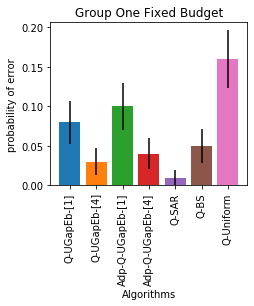

In [6]:
# save results
'''
with open('../saved_results/Group_One_Fixed_Budget.pickle', 'wb') as handle:
     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../saved_results/Group_One_Fixed_Budget.pickle', 'rb') as handle:
    results = pickle.load(handle)
'''
plot_eva(results, 'pe', paper_flag = True, with_para = True, title = 'Group_One_Fixed_Budget', log_scale = False)

## Fixed Confidence 

we consider the problem of ($\epsilon, m , \tau$)-best arm identification problem with $\epsilon = 0.05, m = 1, \tau = 0.5$ and fixed confidence level $1 - \delta = 0.95$. We show the performance of Q-UGapEc with hyperparameter $\beta = [0.01, 0.05]$. We compare our algorithm with i) QPAC ii) MaxQ. The performance is evaluated by the expected sample complexity with 100 repeated experiments. 

In [7]:
# setting

results = defaultdict(dict)
num_arms = 20
num_exper = 100
confi = 0.05
epsilon = 0.05

est_L_flag = True # True: estimate the lower bound of hazard rate L; False: use the true L

In [8]:
hyperpara_list = [[0.01, 1], [0.05, 1]]

run_exper(rewards_env, quantiles, Q_UGapEc, epsilon, m, confi, num_exper, hyperpara_list, est_L_flag = est_L_flag, tau = tau)

hyperpara_list = [[1]]

run_exper(rewards_env, quantiles, QPAC, epsilon, m, confi, num_exper, hyperpara_list, est_L_flag = est_L_flag, tau = tau)

run_exper(rewards_env, quantiles, MaxQ, epsilon, m, confi, num_exper, hyperpara_list, est_L_flag = est_L_flag, tau = tau)

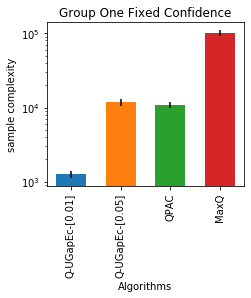

In [9]:
# save results
'''
with open('../saved_results/Group_One_Fixed_Confidence.pickle', 'wb') as handle:
     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../saved_results/Group_One_Fixed_Confidence.pickle', 'rb') as handle:
    results = pickle.load(handle)
'''
plot_eva(results, 'sc', paper_flag = True, with_para = True, title = 'Group_One_Fixed_Confidence', log_scale = True)